Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

# Facial Expression Recognition (FER+) using ONNX Runtime

This example shows how to run inference for a pretrained image classification neural network using the Facial Expression Recognition ([FER](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)) dataset and Open Neural Network eXchange format ([ONNX](http://aka.ms/onnxdocarticle)). This tutorial will show you how to deploy a FER+ model from the [ONNX model zoo](https://github.com/onnx/models) and use it to make predictions using ONNX Runtime Inference.

Throughout this tutorial, we will be referring to ONNX, a neural network exchange format used to represent deep learning models. With ONNX, AI developers can more easily move models between state-of-the-art tools (CNTK, PyTorch, Caffe, MXNet, TensorFlow) and choose the combination that is best for them. ONNX is developed and supported by a community of partners including Microsoft AI, Facebook, and Amazon. For more information, explore the [ONNX website](http://onnx.ai) and [open source files](https://github.com/onnx).

[ONNX Runtime](https://aka.ms/onnxruntime-python) is the runtime engine that enables evaluation of trained machine learning (Traditional ML and Deep Learning) models with high performance and low resource utilization. We use the GPU version of ONNX Runtime in this tutorial, with support for TensorRT.

#### Tutorial Objectives:

1. Describe the FER+ dataset and pretrained Convolutional Neural Net ONNX model for Emotion Recognition, stored in the ONNX model zoo.
2. Run the FER+ ONNX model in an environment with CUDA, CUDNN, and TensorRT alongside ONNX Runtime.

### Download sample data and pre-trained ONNX model from ONNX Model Zoo.

In the following lines of code, we download [the trained ONNX Emotion FER+ model and corresponding test data](https://github.com/onnx/models/tree/master/emotion_ferplus) and place them in the same folder as this tutorial notebook. For more information about the FER+ dataset, please visit Microsoft Researcher Emad Barsoum's [FER+ source data repository](https://github.com/ebarsoum/FERPlus).

In [32]:
import urllib.request
import numpy as np
import onnxruntime
import sys
import os
import time
import onnx
from onnx import numpy_helper
import cv2

# for images and plots in this notebook
import matplotlib.pyplot as plt  
from IPython.display import Image

# display images inline
%matplotlib inline

In [33]:
# urllib is a built-in Python library to download files from URLs

# Objective: retrieve the latest version of the ONNX Emotion FER+ model files from the
# ONNX Model Zoo and save it in the same folder as this tutorial

onnx_model_url = "https://www.cntk.ai/OnnxModels/emotion_ferplus/opset_7/emotion_ferplus.tar.gz"

urllib.request.urlretrieve(onnx_model_url, filename="emotion_ferplus.tar.gz")

# the ! magic command tells our jupyter notebook kernel to run the following line of 
# code from the command line instead of the notebook kernel

# We use tar and xvcf to unzip the files we just retrieved from the ONNX model zoo

!tar xvzf emotion_ferplus.tar.gz

emotion_ferplus/
emotion_ferplus/model.onnx
emotion_ferplus/test_data_set_0/
emotion_ferplus/test_data_set_0/input_0.pb
emotion_ferplus/test_data_set_0/output_0.pb
emotion_ferplus/test_data_set_1/
emotion_ferplus/test_data_set_1/input_0.pb
emotion_ferplus/test_data_set_1/output_0.pb
emotion_ferplus/test_data_set_2/
emotion_ferplus/test_data_set_2/input_0.pb
emotion_ferplus/test_data_set_2/output_0.pb


### ONNX FER+ Model Methodology

The image classification model we are using is pre-trained using Microsoft's deep learning cognitive toolkit, [CNTK](https://github.com/Microsoft/CNTK), from the [ONNX model zoo](http://github.com/onnx/models). The model zoo has many other models that can be deployed on cloud providers like AzureML without any additional training. To ensure that our cloud deployed model works, we use testing data from the well-known FER+ data set, provided as part of the [trained Emotion Recognition model](https://github.com/onnx/models/tree/master/emotion_ferplus) in the ONNX model zoo.

The original Facial Emotion Recognition (FER) Dataset was released in 2013 by Pierre-Luc Carrier and Aaron Courville as part of a [Kaggle Competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data), but some of the labels are not entirely appropriate for the expression. In the FER+ Dataset, each photo was evaluated by at least 10 croud sourced reviewers, creating a more accurate basis for ground truth. 

You can see the difference of label quality in the sample model input below. The FER labels are the first word below each image, and the FER+ labels are the second word below each image.

![](https://raw.githubusercontent.com/Microsoft/FERPlus/master/FER+vsFER.png)

***Input: Photos of cropped faces from FER+ Dataset***

***Task: Classify each facial image into its appropriate emotions in the emotion table***

```    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 'anger':4, 'disgust':5, 'fear':6, 'contempt':7} ```

***Output: Emotion prediction for input image***


### Model Description

The FER+ model from the ONNX Model Zoo is summarized by the graphic below. You can see the entire workflow of our pre-trained model in the following image from Barsoum et. al's paper ["Training Deep Networks for Facial Expression Recognition
with Crowd-Sourced Label Distribution"](https://arxiv.org/pdf/1608.01041.pdf), with our (64 x 64) input images and our output probabilities for each of the labels.

![](https://raw.githubusercontent.com/vinitra/FERPlus/master/emotion_model_img.png)

In [34]:
model_dir = "emotion_ferplus"
model = os.path.join(model_dir, "model.onnx")
session = onnxruntime.InferenceSession(model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name 

## Testing and Evaluation

### Useful Helper Functions

We preprocess and postprocess our data (see score.py file) using the helper functions specified in the [ONNX FER+ Model page in the Model Zoo repository](https://github.com/onnx/models/tree/master/emotion_ferplus).

In [35]:
def emotion_map(classes, N=1):
    """Take the most probable labels (output of postprocess) and returns the 
    top N emotional labels that fit the picture."""
    
    emotion_table = {0:'neutral', 
                     1:'happiness', 
                     2:'surprise', 
                     3:'sadness', 
                     4:'anger', 
                     5:'disgust', 
                     6:'fear', 
                     7:'contempt'}
    
    
    if N==1:
        return emotion_table[classes[0]]

    emotions = []
    for i in range(N):
        emotions.append(emotion_table[classes[i]])
    return emotions

def softmax(x):
    """Compute softmax values (probabilities from 0 to 1) for each possible label."""
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(results):
    """This function takes the scores generated by the network and 
    returns the class IDs in decreasing order of probability."""
    scores = np.array(results)
    prob = softmax(scores)
    prob = np.squeeze(prob)
    classes = np.argsort(prob)[::-1]
    return classes

### Load Test Data

These are already in your directory from your ONNX model download (from the model zoo).

Notice that our Model Zoo files have a .pb extension. This is because they are [protobuf files (Protocol Buffers)](https://developers.google.com/protocol-buffers/docs/pythontutorial), so we need to read in our data through our ONNX TensorProto reader into a format we can work with, like numerical arrays.

In [36]:
test_inputs = []
test_outputs = []

# read in 3 testing images from .pb files
test_data_size = 3

for i in np.arange(test_data_size):
    input_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'input_0.pb')
    output_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'output_0.pb')
    
    # convert protobuf tensors to np arrays using the TensorProto reader from ONNX
    tensor = onnx.TensorProto()
    with open(input_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    input_data = numpy_helper.to_array(tensor)
    test_inputs.append(input_data)
    
    with open(output_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    output_data = numpy_helper.to_array(tensor)
    output_processed = emotion_map(postprocess(output_data))
    test_outputs.append(output_processed)

### Show some sample images
We use `matplotlib` to plot 3 test images from the dataset.

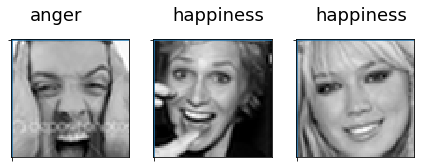

In [37]:
plt.figure(figsize = (20, 20))
for test_image in np.arange(3):
    test_inputs[test_image].reshape(1, 64, 64)
    plt.subplot(1, 8, test_image+1)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = test_outputs[test_image], fontsize = 18)
    plt.imshow(test_inputs[test_image].reshape(64, 64), cmap = plt.cm.gray)
plt.show()

### Run evaluation / prediction

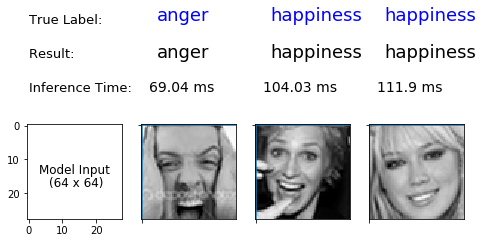

In [38]:
plt.figure(figsize = (16, 6), frameon=False)
plt.subplot(1, 8, 1)

plt.text(x = 0, y = -30, s = "True Label: ", fontsize = 13, color = 'black')
plt.text(x = 0, y = -20, s = "Result: ", fontsize = 13, color = 'black')
plt.text(x = 0, y = -10, s = "Inference Time: ", fontsize = 13, color = 'black')
plt.text(x = 3, y = 14, s = "Model Input", fontsize = 12, color = 'black')
plt.text(x = 6, y = 18, s = "(64 x 64)", fontsize = 12, color = 'black')
plt.imshow(np.ones((28,28)), cmap=plt.cm.Greys)    


for i in np.arange(test_data_size):
    start = time.time()
    r = session.run([output_name], {input_name : test_inputs[i]})
    end = time.time()
    
    result = emotion_map(postprocess(r))
    ground_truth = test_outputs[i]
    time_ms = np.round((end-start) * 1000, 2)
    
    # compare actual value vs. the predicted values:
    plt.subplot(1, 8, i+2)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if ground_truth != result else 'black'
    clr_map = plt.cm.Greys if ground_truth != result else plt.cm.gray

    # ground truth labels are in blue
    plt.text(x = 10, y = -70, s = ground_truth, fontsize = 18, color = 'blue')
    
    # predictions are in black if correct, red if incorrect
    plt.text(x = 10, y = -45, s = result, fontsize = 18, color = font_color)
    plt.text(x = 5, y = -22, s = str(time_ms) + ' ms', fontsize = 14, color = font_color)
    plt.imshow(test_inputs[i].reshape(64, 64), cmap = clr_map)

plt.show()

### Try classifying your own images!

In [39]:
# Preprocessing functions take your image and format it so it can be passed
# as input into our ONNX model

def rgb2gray(rgb):
    """Convert the input image into grayscale"""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def resize_img(img):
    """Resize image to MNIST model input dimensions"""
    img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_AREA)
    img.resize((1, 1, 64, 64))
    return img

def preprocess(img):
    """Resize input images and convert them to grayscale."""
    if img.shape == (64, 64):
        img.resize((1, 1, 64, 64)).astype(np.float32)
        return img
    
    grayscale = rgb2gray(img)
    processed_img = resize_img(grayscale)
    processed_img = processed_img.astype(np.float32)
    return processed_img

Old Dimensions:  (612, 612, 3)
New Dimensions:  (1, 1, 64, 64)


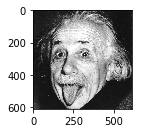

In [40]:
# Replace the following string with your own path/test image
# Make sure your image is square and the dimensions are equal (i.e. 100 * 100 pixels or 28 * 28 pixels)

# Any PNG or JPG image file should work
# Make sure to include the entire path with // instead of /

# e.g. your_test_image = "C:/Users/vinitra.swamy/Pictures/face.png"

your_test_image = "einstein.jpg"

import matplotlib.image as mpimg

if your_test_image != "<path to file>":
    img = mpimg.imread(your_test_image)
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = plt.cm.Greys)
    print("Old Dimensions: ", img.shape)
    img = preprocess(img)
    print("New Dimensions: ", img.shape)
else:
    img = None

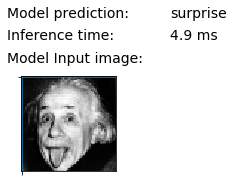

In [41]:
if img is None:
    print("Add the path for your image data.")
else:
    start = time.time()
    r = session.run([output_name], {input_name: img})
    end = time.time()
    
    result = emotion_map(postprocess(r))
    time_ms = np.round((end-start) * 1000, 2)

    plt.figure(figsize = (16, 6))
    plt.subplot(1,8,1)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = -10, y = -40, s = "Model prediction: ", fontsize = 14)
    plt.text(x = -10, y = -25, s = "Inference time: ", fontsize = 14)
    plt.text(x = 100, y = -40, s = str(result), fontsize = 14)
    plt.text(x = 100, y = -25, s = str(time_ms) + ' ms', fontsize = 14, color = font_color)
    plt.text(x = -10, y = -10, s = "Model Input image: ", fontsize = 14)
    plt.imshow(img.reshape((64, 64)), cmap = plt.cm.gray)         

## Conclusion

Congratulations!

In this tutorial, you have:
- familiarized yourself with ONNX Runtime inference and the pretrained models in the ONNX model zoo
- understood a state-of-the-art convolutional neural net image classification model (FER+ in ONNX) and deployed it using ONNX Runtime and TensorRT
- ensured that your deep learning model is working perfectly on test data, and checked it against some of your own!

Next steps:
- If you have not already, check out another interesting ONNX/AML application that lets you set up a state-of-the-art [handwritten image classification model (MNIST)](https://github.com/Azure/MachineLearningNotebooks/tree/master/onnx/onnx-inference-mnist.ipynb) in the cloud! This tutorial deploys a pre-trained ONNX Computer Vision model for handwritten digit classification in an Azure ML virtual machine.
- Keep an eye out for an updated version of this tutorial that uses ONNX Runtime GPU.
- Contribute to our [open source ONNX repository on github](http://github.com/onnx/onnx) and/or add to our [ONNX model zoo](http://github.com/onnx/models)